##  <center> BRISTOL AIRBNB PROPERTIES - PRICE REGRESSION</center>

### <CENTER> Introduction </CENTER>

The purpose of this project is the exploration of the Bristol properties listed on Airbnb and the construction of a model able to predict the price of the aforementioned properties, as accurately as possible.
Specifically, the dataset used for the analysis contains various information on these properties, in addition to their price. Therefore the intention is to identify the main features that have a considerable influence on the price and can be used as an input in a machine learning algorithm, in order to produce a meaningful output in terms of price prediction. 
These models can be useful tools that allow you to obtain valuable information and gain insights into the renting market of the area of interest. 

### <CENTER> Exploratory Data Analysis </CENTER>

The inital data mining step revealed some interesting things. <br>
Firstly, it is worth noting that the dimensions of the dataset are rather small, especially in terms of instances that are only 2375. Since machine learning algorithms generally achieve a higher performance when fed with larger amounts of training data, the elimination of a large quantity of rows is not an option in this project, thus the data cleaning step will try to preserve the records as much as possible. 
<br>
There are no duplicate rows, but there are several missing values for the following features: postcode, bathrooms, bedrooms, beds and in most of the columns related to the reviews. Furthermore, many numerical features are an *object* type, containing some string errors. Before continuing with the analysis I transformed these to numerical data type, in order to be able to manipulate them as numerical and gain further insights. The invalid parsing is automatically replaced with NaN.

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score,GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, LinearSVR
from pandas.plotting import scatter_matrix

In [66]:
data=pd.read_csv("C://Users//Mary//Desktop//machine learning assignment//airbnb.csv")
data.head(3)

,id,name,host_id,host_name,neighbourhood,postcode,latitude,longitude,property_type,room_type,...,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365
0,70820,City View - Sarah's double room.,360195,Sarah,Windmill Hill,BS3 4,51.439942,-2.591726,Townhouse,Private room,...,2.10,96,10,9,10,10.0,10.0,10.0,5,44
1,117122,City Centre - Waterside Retreat,591555,Marcus,Clifton,BS8 4UJ,51.450512,-2.610536,Apartment,Private room,...,1.40,99,10,10,10,10.0,10.0,10.0,1,360
2,146407,Sunny Central Artist Cottage (Dbl),708175,Orla,Southville,BS3,51.441308,-2.602706,Townhouse,Private room,...,0.76,91,9,8,9,10.0,9.0,9.0,2,46


In [ ]:
data.shape
data.duplicated().value_counts()
data.info()
data.isnull().sum()

In [67]:
columns=["accommodates","bathrooms","bedrooms","beds","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin"]
data[columns]=data[columns].apply(pd.to_numeric, errors='coerce')

At this point I was able to analyze the summary statistics for the numerical attributes. One thing in particular must be underlined: the presence of outliers that can influence the analysis and must be eliminated. For example, looking at the column related to the people hosted (*accommodates*), there is a property in the dataset that can host 16 people, whereas the mean is only around 3, with a standard deviation of about 2. Furthermore, 75% of the properties in the dataset can host less or at most 4 accommodates. Considering that the aim of this project is to predict the market average price, the outliers will not be considered in the analysis. <br>
The attribute that interests us the most is the *price*. Most of the properties have a rather low price: 75% under 85£ per property. The mean price is about 76£, with a fairly high standard deviation of 129£. Besides, the maximum price is 5000£, this is clearly an outlier considering the price distribution.

In [7]:
columns=data.columns[10:28].values.tolist()
data[columns].describe()

,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365
count,2353.000000,2369.000000,2371.000000,2371.000000,2375.000000,2375.000000,2375.000000,2069.000000,2019.000000,2035.000000,2036.000000,2034.000000,2037.000000,2035.000000,2035.000000,2375.000000,2375.000000
mean,3.116872,1.253482,1.435049,1.809785,76.600842,2.825263,31.608842,2.193823,94.868252,10.438329,9.643910,9.823009,9.832597,9.555283,9.474693,6.943579,121.521263
std,2.152840,0.638382,0.982333,1.539797,129.165841,13.122816,51.215247,2.197518,7.128126,7.608120,2.636619,0.555916,0.577031,0.670538,0.802358,16.766377,128.369568
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.020000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,35.000000,1.000000,2.000000,0.570000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,59.000000,2.000000,11.000000,1.450000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,71.000000
75%,4.000000,1.000000,2.000000,2.000000,85.000000,2.000000,38.000000,3.100000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000,225.500000
max,16.000000,12.500000,13.000000,24.000000,5000.000000,365.000000,477.000000,18.030000,100.000000,100.000000,99.000000,10.000000,10.000000,10.000000,10.000000,78.000000,365.000000


The next step was to look at the correlation coefficient between the price and the other numerical variables of the dataset. The price has some degree of correlation with the number of *beds*, of *accommodates*, of *bedrooms* and *bathrooms* but it does not have a linear relationship with any other feature. As expected, larger properties have a higher price.  However the correlation coefficient identifies only linear relationships. 

In [8]:
correlation=data[columns].corr()
correlation['price'].sort_values(ascending=True)

review_scores_value              -0.089866
number_of_reviews                -0.071594
reviews_per_month                -0.048298
review_scores_accuracy           -0.018468
minimum_nights                   -0.011993
review_scores_communication      -0.001458
review_scores_checkin             0.005241
review_scores_cleanliness         0.005252
calculated_host_listings_count    0.010352
review_scores_rating              0.011933
review_scores_location            0.044286
availability_365                  0.098668
bathrooms                         0.320903
bedrooms                          0.437407
accommodates                      0.479306
beds                              0.508491
price                             1.000000
Name: price, dtype: float64

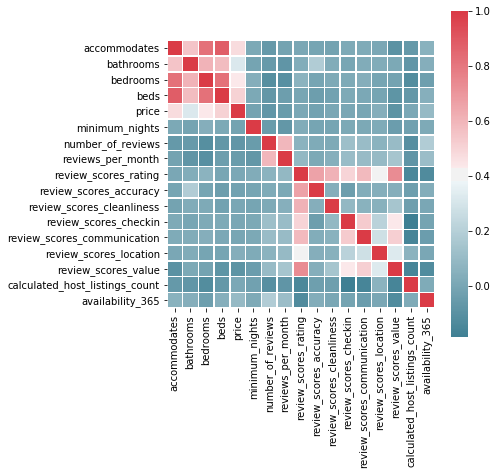

In [9]:
correlation=data[columns].corr()
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, square=True, linewidths=0.5, cmap=cmap)

The next step was to plot the price against each other numerical variable to identify other relationships that are not captured by the correlation coefficient. To better highlight the patterns, I first eliminated the price-related outliers that would influence the scatter plots. Taking the price distribution as a point of reference, I eliminated the tails (1% of the distribution on each side), consisting of 40 instances: the shape of the dataframe is now 2335 rows x 28 columns. 

In [68]:
lowerp=np.percentile(data.price,1)
upperp=np.percentile(data.price,99)
data.drop(data[data.price < lowerp].index | data[data.price>upperp].index, inplace=True, axis=0)
data.shape

(2335, 28)

In [331]:
columns1=["price","accommodates","bathrooms","bedrooms","beds","minimum_nights","number_of_reviews","reviews_per_month"]
columns2=["price","review_scores_rating","review_scores_accuracy","review_scores_cleanliness",'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value', 'calculated_host_listings_count', 'availability_365']

The linear and positive relationship between the price and accommodates, beds, bathrooms and bedrooms is very clear now. Furthermore, there is a non-linear relationship between the price and the reviews per month and the number of reviews. Both variables have an inverse curved relationship with the price. Properties that are more expensive have a lower number of reviews per month and number of reviews in total whereas the opposite applies to cheaper properties.<br> As for the second chart, the reviews ratings are mostly located in the right hand side of the plots, meaning that they are overall fairly high, as it also emerged in the aforementioned summary statistics. Also the properties with higher prices do not seem to have low-rated reviews.

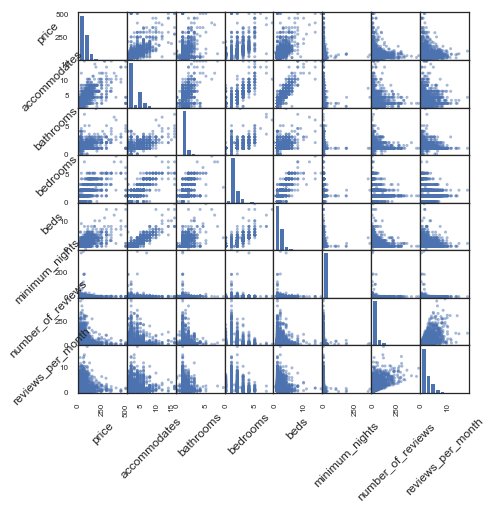

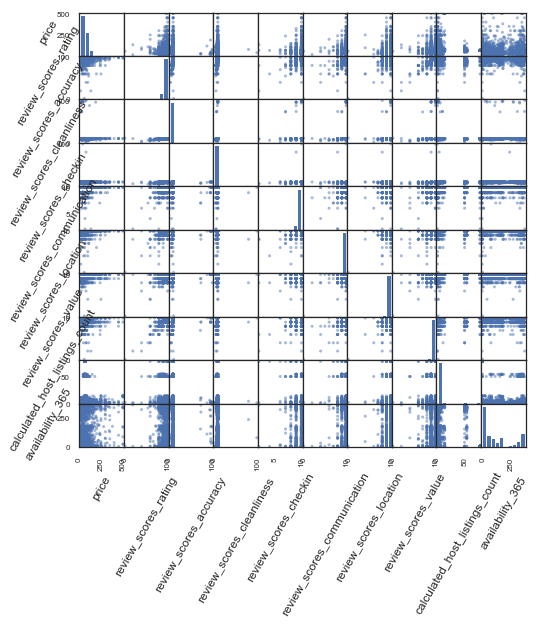

In [333]:
sm=scatter_matrix(data[columns1],figsize=(7, 7))
sm2=scatter_matrix(data[columns2],figsize=(8, 8))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.xaxis.label.set_rotation(60) for s in sm2.reshape(-1)]
[s.yaxis.label.set_rotation(60) for s in sm2.reshape(-1)]
plt.show()

In order to better understand the distribution of the prices, I plotted an histogram, where the price is limited to the interval 0-300, as the observations over this value are not many. Overall the properties have a price that is less than 100, whereas the observations with higher prices are not many. More specifically, the histogram highlights a bimodal distribution, with two peaks, one at a price of about 20/30£ and the other at about 70/80£, meaning that a large number of properties have a price within this spectrum. 

Text(0.5, 0, 'Price')

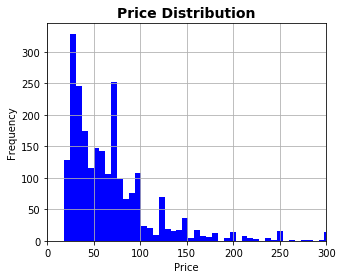

In [183]:
data.price.plot(kind="hist",bins=60, figsize=(5,4), color="blue")
plt.grid()
plt.xlim([0,300])
plt.title("Price Distribution", weight="bold",fontsize=14)
plt.xlabel("Price")

Another interesting aspect concerns the position of the property. Plotting the price against the latitude and the longitude it is clear that the higher prices, over 100£, are concentrated in specific areas. As we could have expected,the location of the property also has a big impact on the price. Looking at the latitude, the trend is very clear: the prices increase gradually when approaching latitude=51.46, from both sides, if we exlude some outliers. Looking at the longitude, there is the same trend of higher prices in the range -2.625 and -2.575. This is probably the City centre, thus we're going to explore this aspect by looking at the average prices per property for each neighbourhood. 

Text(0.5, 1.0, 'Price variation with longitude')

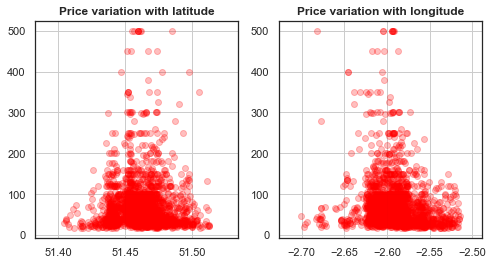

In [369]:
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.scatter(data["latitude"],data["price"], alpha=0.25,marker="o", color="red")
plt.grid()
plt.title("Price variation with latitude",weight='semibold', fontsize=12)
plt.subplot(1,2,2)
plt.scatter(data["longitude"],data["price"], alpha=0.25,marker="o", color="red")
plt.grid()
plt.title("Price variation with longitude",weight='semibold', fontsize=12)

Text(0.5, 1.0, 'Average price per neighbourhood')

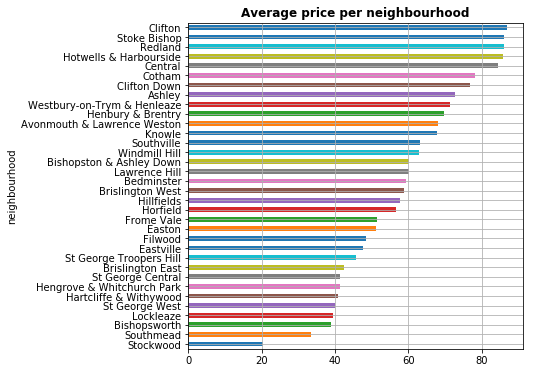

In [13]:
data.groupby(["neighbourhood"])["price"].mean().sort_values(ascending=True).plot(kind="barh",figsize=(6,6)) 
plt.grid()
plt.title("Average price per neighbourhood",weight='semibold', fontsize=12)

The Central neighbourhood is one of those with a higher price on average, compared to the others. The neighbourhoods can be divided into 4 average price bands: 80-100 (high price on average - Clifton, Stoke Bishop, Redland and Hotwells & Harbourside, as well as Central), 60-80 (medium-high), 40-60 (medium-low) and less than 40 (low price on average). Once again the position is fundamental for the price. <br>
The last aspect that must be explored concerns the property type. Considering that the *property_type* feature has many inaccurate entries, some data cleaning and transformations must be done in the first place.

In [ ]:
data["property_type"].value_counts()
data["room_type"].value_counts()

### <CENTER> Data cleansing and feature engineering </CENTER>

As aforementioned, the main goal at this stage is to preserve the dataset dimensions.<br>
To start, the properties that are not frequent in the dataset and represent less than 5% of the number of observations are gouped together in the "Other" category. The properties are now grouped in 5 categories: apartments and houses are the most substantial classes, representing together around 75% of the observations, plus other 3 classes with fewer observations. The dataset is therefore highly unbalanced. <br>
The missing values in the accommodates and beds columns are filled with the median value for each room type. The median was chosen as it is less sensitive to outliers compared to the mean. For example, the median number of accommodates for the private rooms is 2 whereas for entire home/apt is 4, these two values will be used to replace the missing values accordingly.<br>
The missing values for the number of bathrooms and bedrooms are filled following a similar logic, but referring to the property type instead of the room. <br>
The following step consisted of grouping together the shared and the private rooms, considering that the number of shared rooms is very low (only 7) and the 2 types of properties are similar. 

In [69]:
count_property=pd.DataFrame(data["property_type"].value_counts())
count_property.columns=["count"]
count_property["property"]=count_property.index
cancel=count_property.loc[count_property["count"]<0.05*len(data)]
cancel2=pd.Series(cancel["property"])
data.loc[data["property_type"].isin(cancel2) , "property_type"]="Other" 
data.property_type.value_counts()

Apartment             913
House                 820
Townhouse             227
Other                 188
Serviced apartment    187
Name: property_type, dtype: int64

In [ ]:
data.groupby('room_type')["accommodates"].median()
data.groupby('room_type')["bedrooms"].median()
data.groupby('property_type')["bathrooms"].median()
data.groupby('property_type')["beds"].median()

In [70]:
data.loc[(data['room_type']=="Private room") & (data.accommodates.isnull()), "accommodates" ]= 2
data.loc[(data['room_type']=="Entire home/apt") & (data.accommodates.isnull()), "accommodates" ]=4
data.loc[(data['room_type']=="Shared room") & (data.accommodates.isnull()), "accommodates" ]=2
data.loc[(data['room_type']=="Private room") & (data.beds.isnull()), "beds" ]=1
data.loc[(data['room_type']=="Entire home/apt") & (data.beds.isnull()), "beds" ]=2
data.loc[(data['room_type']=="Shared room") & (data.beds.isnull()), "beds" ]=2
data.loc[data['bedrooms'].isnull(),'bedrooms']=1
data.loc[data['bathrooms'].isnull(),'bathrooms']=1

In [71]:
data.loc[(data['room_type']=="Shared room")| (data["room_type"]=="Private room"), "room_type" ]="Room"

Considering that the 2 columns *property_type* and *room_type* concern the same information, I combined them in an unique feature, in order to distinguish between rooms in apartments, houses, townhouses, serviced apartments or another type of property and listings that concern the whole apartment, house, townhouse, serviced apartment or another property type. In fact the price is influenced by the type of property and by the fact that it is rented entirely or only by rooms, as shown in the figure below that dislays the price distributions for each property type. It is clear that properties that are rented as a whole are more expensive than the rooms. Most of the rooms have a price less than 50£; however some rooms in apartments or another property type are more expensive, priced between 50-100£. The apartments that are rented on Airbnb are overall less expensive than entire houses/townhouses: their price is in the range 30-150£, a part from some outliers, whereas for the houses and townhouses the range is about 30-250£. Obviously within these categories the prices vary depending on the number of bathrooms, beds.

In [72]:
data["Property"]=""

In [73]:
data.loc[(data['room_type']=="Room")& (data["property_type"]=="Apartment"), "Property" ]="Room in apt"
data.loc[(data['room_type']=="Room")& (data["property_type"]=="House"), "Property" ]="Room in house"
data.loc[(data['room_type']=="Room")& (data["property_type"]=="Townhouse"), "Property" ]="Room in townhouse"
data.loc[(data['room_type']=="Room")& (data["property_type"]=="Other"), "Property" ]="Room in other"
data.loc[(data['room_type']=="Room")& (data["property_type"]=="Serviced apartment"), "Property" ]="Room in serviced apt"
data.loc[(data['room_type']=="Entire home/apt")& (data["property_type"]=="Apartment"), "Property" ]="Entire apartment"
data.loc[(data['room_type']=="Entire home/apt")& (data["property_type"]=="House"), "Property" ]="Entire house"
data.loc[(data['room_type']=="Entire home/apt")& (data["property_type"]=="Townhouse"), "Property" ]="Entire townhouse"
data.loc[(data['room_type']=="Entire home/apt")&(data["property_type"]=="Serviced apartment"), "Property" ]="Entire serviced apt"
data.loc[(data['room_type']=="Entire home/apt")& (data["property_type"]=="Other"), "Property" ]="Entire - other"
data.Property.value_counts()

Entire apartment        633
Room in house           545
Room in apt             280
Entire house            275
Entire serviced apt     180
Room in townhouse       162
Room in other           113
Entire - other           75
Entire townhouse         65
Room in serviced apt      7
Name: Property, dtype: int64

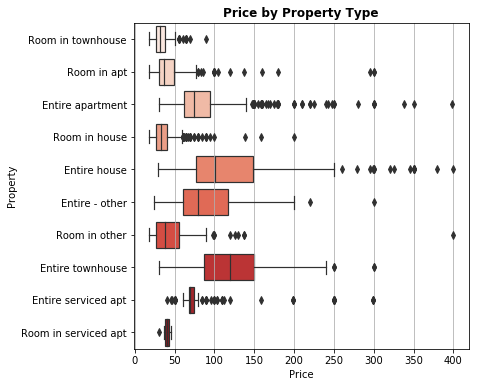

In [20]:
plt.figure(figsize=[6,6])
plt.grid()
data2=data[["price","Property"]]
sns.boxplot(x=data2["price"], y=data2["Property"], data=pd.melt(data2), orient="h",palette="Reds", linewidth=1.2)
plt.title("Price by Property Type", fontsize=12, weight='semibold')
plt.xlabel('Price')
plt.show()

In [74]:
data = data.reset_index()

The next step is to fill the missing values for *review_scores_value* and *number_of_reviews*, using a machine learning predictor, as these 2 features have a relationship with the price, as previously mentioned. Furthermore the correlation coefficient increased after the elimination of the outliers. For brevity I used only a SVR, without fine-tuning of the hyperparameters, but the correct approach would involve a comparison of different regressors.

In [27]:
correlation=data[columns].corr()
correlation['price'].sort_values(ascending=True)

review_scores_value              -0.117221
number_of_reviews                -0.108020
reviews_per_month                -0.074769
review_scores_accuracy           -0.026712
review_scores_checkin            -0.021600
review_scores_communication      -0.016625
minimum_nights                   -0.011702
review_scores_rating             -0.007732
review_scores_cleanliness        -0.000948
calculated_host_listings_count    0.024652
review_scores_location            0.078625
availability_365                  0.098866
bathrooms                         0.430986
beds                              0.652114
bedrooms                          0.653740
accommodates                      0.706960
price                             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price variation and number of reviews')

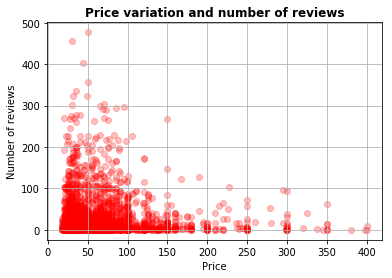

In [35]:
plt.scatter(data["price"],data["number_of_reviews"], alpha=0.25,marker="o", color="red")
plt.grid()
plt.xlabel("Price")
plt.ylabel("Number of reviews")
plt.title("Price variation and number of reviews",weight='semibold', fontsize=12)

In [76]:
data_to_train=data[data['review_scores_value'].notnull()]
X=data_to_train.loc[:, "accommodates":"minimum_nights"]
y=data_to_train['review_scores_value']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15,random_state=42)
svr=Pipeline([("scaler",StandardScaler()), ("linear_svr",SVR(kernel='poly', degree=2, coef0=10, C=5))])
svr.fit(X_train,y_train)
y_pred2=svr.predict(X_test)
print(mean_squared_error(y_test, y_pred2))
for i in data[data['review_scores_value'].isnull()].index.values:
    prediction=svr.predict((data.loc[i,"accommodates":"minimum_nights"]).values.reshape(1,-1))
    data.at[i,"review_scores_value"]=prediction

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWar

0.8900723625374731


C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarnin

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarnin

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarnin

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarnin

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarnin

In [77]:
data_to_train=data[data['number_of_reviews'].notnull()]
X=data_to_train.loc[:, "accommodates":"minimum_nights"]
y=data_to_train['number_of_reviews']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15,random_state=42)
svr=Pipeline([("scaler",StandardScaler()), ("linear_svr",RandomForestRegressor())])
svr.fit(X_train,y_train)
y_pred2=svr.predict(X_test)
print(mean_squared_error(y_test, y_pred2))
for i in data[data['number_of_reviews'].isnull()].index.values:
    prediction=svr.predict((data.loc[i,"accommodates":"minimum_nights"]).values.reshape(1,-1))
    data.at[i,"number_of_reviews"]=prediction

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3487.38761430708


C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### <center> Price prediction <center>

#### Simple Linear Regression 

Considering the rather high degree of correlation between the price and the number of people housed, it seems reasonable to start with a simple linear regression, with only the number of accommodates as predictor variable, in order to assess the performance of this model and use it as a baseline in the next steps of the analysis where more complex models will be evaluated, using also a larger set of attributes. <br>
Firstly, I set the target (*price*) and the predictors (only *accommodates* in this case) and divided the dataset into a training set that will be used for training the models, and a testing set that will be used only for evaluation.

In [58]:
y=data["price"]
columns=["accommodates"]
X=data[columns]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, random_state=42)

In [59]:
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
print("Linear Regression Intercept:",lin_reg.intercept_)
print("Linear Regression Coefficient:",lin_reg.coef_)
print("Linear Regression Equation:","price=", round(lin_reg.intercept_,4),"+",round(lin_reg.coef_.item(),4),"*n. accommodates")

Linear Regression Intercept: 11.748712955907976
Linear Regression Coefficient: [18.75033763]
Linear Regression Equation: price= 11.7487 + 18.7503 *n. accommodates


In [194]:
data.groupby("accommodates")["price"].mean()

accommodates
1.0      30.819923
2.0      49.613322
3.0      68.247706
4.0      87.222477
5.0     105.785714
6.0     123.737805
7.0     137.687500
8.0     153.591837
9.0     205.846154
10.0    232.071429
11.0    255.250000
12.0    241.666667
14.0    245.000000
15.0    179.000000
16.0    244.750000
Name: price, dtype: float64

The intercept of the model is 11 whereas the slope is about 19. When the number of accommodates is 1, the model predicts an average price of about 30.46£; when the number of accommodates is 2, it will predict a price of around 50£, and so on. Looking at the average price based on the number of the accommodates, the model looks reasonable. However, the price doesn't depend only on the number of people that the property can accommodate. Not all the houses that can accommodate 1 person will have the same price, based for example on the location, as previously mentioned. This is evident when plotting the regression line over the scatter plot of the price against the accommodates. The variance in the price for each group of property that can accommodate the same number of people is not taken into account in this simplistic model. <br>

Text(0.5, 1.0, 'Linear Regression Accommodates-Price')

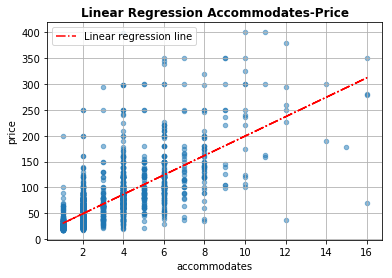

In [195]:
data.groupby("accommodates")["price"].mean()
predictions=lin_reg.predict(X)
data.plot(kind="scatter",x="accommodates",y="price", alpha=0.5,marker="o")
plt.plot(X,predictions, "r-.", label="Linear regression line")
plt.grid()
plt.legend()
plt.title("Linear Regression Accommodates-Price",weight='semibold', fontsize=12)

The next step is to evaluate the model using the Root Mean Squared Error (RMSE). Looking at the scores it looks like the model is underfitting as it performs poorly on both the training and the testing set. For consistency I used cross validation with 5 folds on the training set. The Root Mean Square Error is fairly high (around 37 on the training set), considering the average price of 71.54£ after eliminating the outliers. A more complex model must be built, and more features must be added to the model to explain the variance in the price that is not explained by the number of accommodates.  

In [60]:
predlinreg=lin_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predlinreg))
mse=-cross_val_score(lin_reg, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse) 
print("Average RMSE cross validation on training set:" ,rmse2.mean()) 

RMSE on testing set: 33.06810445344044
Average RMSE cross validation on training set: 37.11178490749435


In [61]:
def plot_learning_curves(estimator,X,y):
    X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.15)
    train_errors,val_errors=[],[]
    for m in range(1,len(X_train)):
        estimator.fit(X_train[:m],y_train[:m])
        y_train_predict=estimator.predict(X_train[:m])
        y_val_predict=estimator.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict,y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict,y_val))
    plt.plot(np.sqrt(train_errors),"r-.",linewidth=1,label="Training set")
    plt.plot(np.sqrt(val_errors),"g--",linewidth=1,label="Validation set")

#### Multiple Linear Regression

I built a model that includes the variables that I found that might have an influence on the price, in particular 6 numerical variables, the longitude and the latitude, and the property type. <br> As previously the data is splitted into train-test set but in addition, the features are scaled using the in-built sklearn StandardScaler. The performance of this model is better than the simple linear regression but the model is still underfitting the data: the RMSE is rather high on both the training and the testing set. <br>
The most influent feature in the this model is the number of accommodates, for which the slope of the regression equation is of 15.34. In fact we already mentioned that the strongest linear relationship is between price and accommodates with a correlation coefficient of 0.7 after the elimination of the outliers. Other features with a high influence are the number of bedrooms and some of the properties types. 

In [78]:
data = data.reset_index()

In [93]:
y=data["price"]
columns=["accommodates","beds","bedrooms","latitude","longitude","bathrooms","number_of_reviews","review_scores_value"]
X=data[columns]
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X))
prop=data["Property"]
prop=pd.get_dummies(prop)
X= X.join(prop, how='outer').fillna(0)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, random_state=42)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1984, 18) (1984,)
(351, 18) (351,)


C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [94]:
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
predlinreg=lin_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predlinreg))
mse=-cross_val_score(lin_reg, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 

print("RMSE on testing set:" ,rmse)
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 
print("*****")
print("Linear Regression Intercept:",lin_reg.intercept_)
print("Linear Regression Coefficients:",lin_reg.coef_)

RMSE on testing set: 29.652414864276327
Average RMSE cross-validation on training set: 33.467543972664586
*****
Linear Regression Intercept: 67.65358154506602
Linear Regression Coefficients: [ 14.53882791   4.10831422  13.67136266   0.31681344  -4.93873069
   5.47007754  -1.66578574  -1.20304675  16.31490166  15.79008037
   2.8377652   26.04036798   0.76403201  -5.62545103 -14.31634553
  -8.58739449 -15.77049701 -17.44745918]


#### Support Vector Machines

In order to tackle this complex regression task, more advanced models are needed. Support Vector Machines might be adequate considering the dataset is small-medium sized and SVM is suitable for performing nonlinear regression tasks. As previously mentioned, there are some features that do not have a linear relationship with the price, such as the *number_of_reviews*. I tried both the *polynomial* and the *rbf* kernel. <br>
The performance of both the rbf SVM regressor is worse than the linear regression model whereas the polynomial kernel achieves a RMSE similar to linear regression. However the model has still a high RMSE and similar for training and testing set, meaning that the it is not able to fit the training data well and predict new values with unseen data. 

In [82]:
SVR_poly=SVR(kernel='poly', degree=3, coef0=10, C=5)
SVR_poly.fit(X_train, y_train)
predSVR=SVR_poly.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predSVR))
mse=-cross_val_score(SVR_poly, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse) 
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\skle

RMSE on testing set: 30.84738552833768
Average RMSE cross-validation on training set: 33.665724047725


In [84]:
SVR_rbf=SVR(kernel="rbf", gamma=2, C=1000, epsilon=0.1)
SVR_rbf.fit(X_train, y_train)
predSVR2=SVR_rbf.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predSVR2))
mse=-cross_val_score(SVR_rbf, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse)
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 
print("*****")
print("Coefficient of determination, R^2:", SVR_rbf.score(X, y, sample_weight=None))

RMSE on testing set: 43.44033513063712
Average RMSE cross-validation on training set: 44.81491796071339
*****
Coefficient of determination, R^2: 0.8919257868826889


#### Random Forest Regressor

I subsequently trained a Random Forest Regressor to gain more insight into the data and be able to assess the contribution of the features included in the models to the prediction of the prices. Once again, the model underfits the data. 

In [85]:
random_forest=RandomForestRegressor(n_estimators=10, max_leaf_nodes=25,max_depth=8, random_state=42)
random_forest.fit(X_train,y_train)
predrf=random_forest.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predrf))
mse=-cross_val_score(random_forest, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse) 
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 

RMSE on testing set: 30.22265573556967
Average RMSE cross-validation on training set: 32.68610854826307


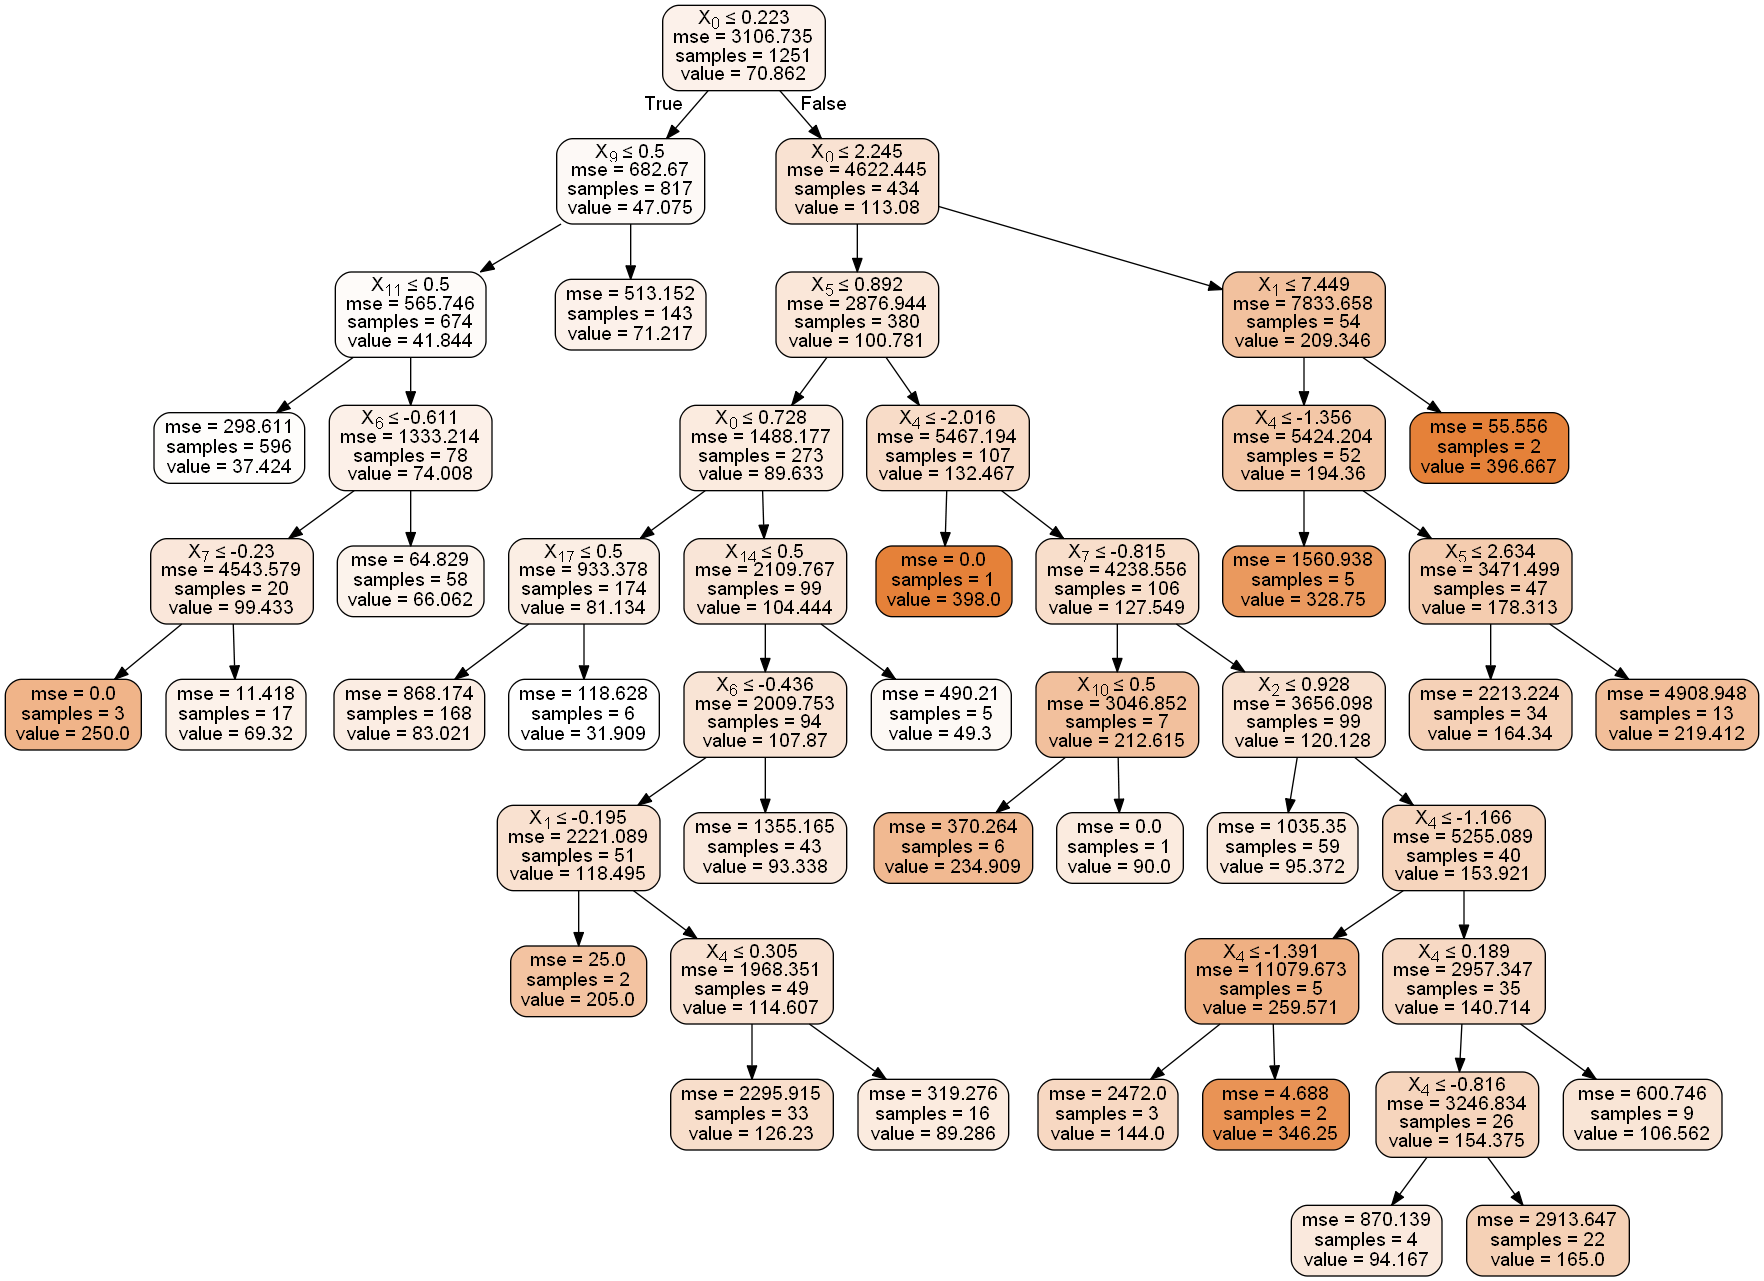

In [212]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
estimator = random_forest.estimators_[5]
export_graphviz(estimator, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The tree above displayed, randomly chosen amongst the 10 estimators of the ensemble method, for explanatory purposes only, allows a better understanding of the features, of the data itself and of how the random forest regressor predicts the prices. The features that occur near the root of the tree are the ones that contribute most to price predictions. In this case is X0, that is the number of accommodates. Some others are not even present. <br> However the tree is only one of the ensemble and is also fairly complex. In order to measure feature importance for the random forest regressor, the importance score is showed below. It is clear that some features are more important than others, starting with the number of accommodates. Furthermore the number of bedrooms is also important but the number of beds has a lower infuence. Some property types are more useful to predict the price than others, such as room in apartment, entire apartment and entire serviced apartment. 

In [86]:
randomreg=RandomForestRegressor(n_estimators=10, n_jobs=-1)
randomreg.fit(X_train, y_train)
for name, score in zip(X.columns, randomreg.feature_importances_):
    print(name,score)

0 0.3691320534883279
1 0.025514692354049906
2 0.16956900482290804
3 0.07114160344310609
4 0.09467476393945387
5 0.05321276731413116
6 0.055482802870269854
7 0.05121333888295523
Entire - other 0.004637539978714479
Entire apartment 0.03867982494415419
Entire house 0.004245615153490799
Entire serviced apt 0.037874648468432706
Entire townhouse 0.0026507939312732996
Room in apt 0.01104853379964706
Room in house 0.0033926486081114053
Room in other 0.001864565517891299
Room in serviced apt 8.172191796001856e-05
Room in townhouse 0.005583080565122765


#### Stochastic Gradient Descent 

The SGD Regressor has a similar performance to the multiple linear regression, RandomForestRegressor and SVR with polynomial kernel. This without parameter tuning, thus it is a good candidate for hyperparameters fine-tuning.

In [95]:
SGD=SGDRegressor(random_state=42)
SGD.fit(X_train,y_train)
predSGD=SGD.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predSGD))
mse=-cross_val_score(SGD, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse) 
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

RMSE on testing set: 30.299432345037843
Average RMSE cross-validation on training set: 33.962009267232105


C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


The predictions of each model are shown in the grahps below, plotted against the true prices. 

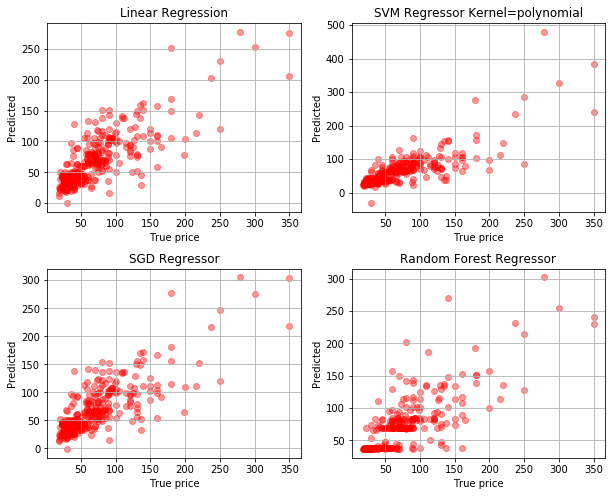

In [97]:
plt.figure(figsize=[10,8])
plt.title("True prices against Predictions")
plt.subplot(2,2,1)
plt.xlabel("True price")
plt.ylabel("Predicted")
plt.grid()
plt.scatter(y_test,predlinreg,marker='o', color="red", alpha=0.4)
plt.title('Linear Regression')
plt.subplot(2,2,2)
plt.xlabel("True price")
plt.ylabel("Predicted")
plt.grid()
plt.scatter(y_test,predSVR,marker='o', color="red", alpha=0.4)
plt.title('SVM Regressor Kernel=polynomial')
plt.subplot(2,2,3)
plt.xlabel("True price")
plt.ylabel("Predicted")
plt.grid()
plt.scatter(y_test,predSGD,marker='o', color="red", alpha=0.4)
plt.title('SGD Regressor')
#plt.xlim([0,300])
#plt.ylim([0,300])
plt.subplot(2,2,4)
plt.xlabel("True price")
plt.ylabel("Predicted")
plt.grid()
#plt.xlim([0,300])
#plt.ylim([0,300])
plt.scatter(y_test,predrf,marker='o', color="red", alpha=0.4)
plt.title('Random Forest Regressor')
plt.subplots_adjust(hspace=0.3)

The SGD regressor and the linear regressor have similar perfomances but the SGD makes less errors on higher prices predictions. Its predictions in fact range over 300 whereas the linear regression model until about 250. The SVM regressor, on the other hand performs well on low prices but systematically underestimates prices that are between 100 and 200. For the random forest it is clear that the prices predicted are not individual but this model predicts an average price. 

#### Grid Search 

In [98]:
print('Parameters currently in use:\n')
print(random_forest.get_params())

Parameters currently in use:

{'bootstrap': True, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': 25, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [99]:
n_estimators=[10,20,30,40,50]
max_depth = [5,10,15,20]
bootstrap = [True, False]
parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

grids = GridSearchCV(random_forest, parameters, cv=5)
grids.fit(X_train, y_train)
grids.best_params_

{'bootstrap': True, 'max_depth': 10, 'n_estimators': 10}

In [100]:
random_forest=RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42, bootstrap=True)
random_forest.fit(X_train,y_train)
predrf=random_forest.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predrf))
mse=-cross_val_score(random_forest, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse) 
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 

RMSE on testing set: 32.36776021076745
Average RMSE cross-validation on training set: 32.01315612422775


In [101]:
loss=["squared_loss","huber","epsilon_insensitive"]
average=[True,False]
parameters = {'loss': loss,
               'average': average}
grids = GridSearchCV(SGD, parameters, cv=5)
grids.fit(X_train, y_train)
grids.best_params_

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

{'average': False, 'loss': 'squared_loss'}

In [102]:
SGD=SGDRegressor(random_state=42, average=False, loss="squared_loss")
SGD.fit(X_train,y_train)
predSGD=SGD.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,predSGD))
mse=-cross_val_score(SGD, X_train,y_train,cv=5,scoring="neg_mean_squared_error")
rmse2=np.sqrt(mse) 
print("RMSE on testing set:" ,rmse) 
print("Average RMSE cross-validation on training set:" ,rmse2.mean()) 

RMSE on testing set: 30.299432345037843
Average RMSE cross-validation on training set: 33.962009267232105


C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Mary\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they

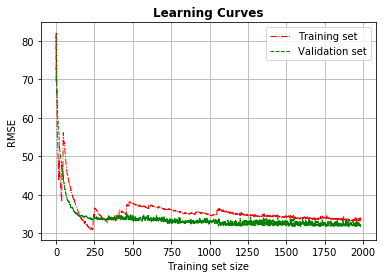

In [103]:
plot_learning_curves(SGD,X,y)  
plt.title("Learning Curves", weight="bold", fontsize=12)
plt.ylabel("RMSE")
plt.xlabel("Training set size")  
plt.legend(loc="best")
plt.grid()
plt.show()

Even using the grid search in an attempt to improve models performances, it is not possible to further reduce the RMSE using the current feature set. <br> The learning curves for the SGD Regressor clearly show the high bias of the model and the necessity of a better feature engineering and selection. 

# <centre> Conclusions and Limitations </centre>

The challenging size of the dataset, together with its complexity and a large irreducible error led to the construction of models that underfit the data. All the algorithms are characterized by high bias and they underfit of the data: the RMSE has a rather high value (around 30), comparing it with the average price of 71.54£, and there is a small or no gap between the training and the validation scores. The models are incapable of both fitting the training data well and generalizing on unseen data. 
Some solutions may involve:
*  transformations of the X features used to train the model, considering the skewed distributions of all the numberical attributes;
*  transformations of the target (price) considering the skewed distribution;
*  exploring different subsets of features for training the model;
*  exploring different methods of filling the missing values (for brevity, in this project I only used one single algorithm to predict the review_scores_value and the number_of_reviews);
*  stratified sampling, ensuring that the training set is representative of the higher prices that are much less common than the lower ones. In fact almost all the models tend to perform poorly on the predictions of more expensive properties, and this impacts the RMSE much more than the errors on the predictions of lower prices. 

As expected, the number of accommodates has a high impact on the price of the properties that are listed on Airbnb for the Bristol area. In addition to this, the number of bedrooms is also fundamental, but the number of beds and bathrooms has a lower impact. Furthermore the more expensive properties have a lower number of reviews, but these have higher rating scores for the "value" of the property, that is, who rated these properties on average think that the property is worth the price. 


